## tensorflow 버전 체크

In [1]:
import tensorflow as tf

In [2]:
tf.__version__  

'2.1.0'

## GPU 사용 체크

In [3]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


## Library Package

In [4]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D,Dropout, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input, optimizers

import cv2
import warnings

## 데이터 불러오기

In [5]:
IMAGE_PATH = '../../Data/final_data/training/cctv_data'
file_directory = os.getcwd()
print(file_directory)
rainy_list = glob.glob(os.path.join(IMAGE_PATH, 'flood/*.jpg'))
normal_list = glob.glob(os.path.join(IMAGE_PATH, 'no_flood_new/*.jpg'))

C:\Users\pcrmc\Desktop\venv\dataflood\ML_model_code\Video_Model


In [6]:
abnormal_img = img_to_array(load_img(rainy_list[1]), dtype=np.uint8)
normal_img = img_to_array(load_img(normal_list[1]), dtype=np.uint8)

## chale 화소 전처리

In [7]:
def Clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(4,4))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr

In [8]:
for i in range(len(rainy_list)):
    abnormal_img = img_to_array(load_img(rainy_list[i]), dtype=np.uint8)
    abnormal_img = abnormal_img[130:800, 710:1380]
    print(abnormal_img)
    img_yuv = cv2.cvtColor(abnormal_img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    histo_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    clahe = Clahe(abnormal_img)
    
    cv2.imwrite(os.path.join(IMAGE_PATH,'flood_clahe/flood{}.jpg').format(i), cv2.cvtColor(clahe, cv2.COLOR_BGR2RGB))

for i in range(len(normal_list)):
    normal_img = img_to_array(load_img(normal_list[i]), dtype=np.uint8)
    normal_img = normal_img[235:400, 260:560]

    img_yuv = cv2.cvtColor(normal_img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    histo_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    clahe = Clahe(normal_img)
    
    cv2.imwrite(os.path.join(IMAGE_PATH,'no_flood_new_clahe/no_flood{}.jpg').format(i), cv2.cvtColor(clahe, cv2.COLOR_BGR2RGB))


[[[ 80  81  85]
  [ 77  78  82]
  [ 71  72  76]
  ...
  [124 128 103]
  [124 128 103]
  [120 124  99]]

 [[ 93  94  98]
  [ 93  94  98]
  [ 86  87  91]
  ...
  [130 135 105]
  [129 134 104]
  [125 130 100]]

 [[105 106 110]
  [106 107 111]
  [ 98  99 103]
  ...
  [132 138 104]
  [130 136 102]
  [127 133  99]]

 ...

 [[194 206 206]
  [193 205 205]
  [192 204 204]
  ...
  [ 95 105 107]
  [ 95 105 107]
  [ 95 105 107]]

 [[194 206 206]
  [193 205 205]
  [192 204 204]
  ...
  [ 94 104 106]
  [ 95 105 107]
  [ 95 105 107]]

 [[194 206 206]
  [193 205 205]
  [192 204 204]
  ...
  [ 94 104 106]
  [ 94 104 106]
  [ 95 105 107]]]
[[[30 34 37]
  [30 34 37]
  [27 32 35]
  ...
  [66 68 57]
  [67 69 56]
  [65 67 53]]

 [[31 35 38]
  [30 34 37]
  [26 31 34]
  ...
  [73 75 61]
  [73 76 59]
  [71 74 55]]

 [[30 34 37]
  [29 33 36]
  [26 30 33]
  ...
  [83 86 67]
  [83 86 65]
  [81 85 62]]

 ...

 [[61 63 62]
  [62 64 63]
  [61 63 62]
  ...
  [60 63 68]
  [60 63 68]
  [60 63 68]]

 [[59 63 62]
  [59 6

## clahe 처리된 데이터 불러오기

In [9]:
IMAGE_PATH = '../../Data/final_data/training/cctv_data'
file_directory = os.getcwd()
print(file_directory)
rainy_list = glob.glob(os.path.join(IMAGE_PATH, 'flood_clahe/*.jpg'))
normal_list = glob.glob(os.path.join(IMAGE_PATH, 'no_flood_new_clahe/*.jpg'))

C:\Users\pcrmc\Desktop\venv\dataflood\ML_model_code\Video_Model


## GPU 더블체크

In [10]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

c:\users\pcrmc\desktop\venv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: No GPU found. Please use a GPU to train your neural network.
  This is separate from the ipykernel package so we can avoid doing imports until


## 학습 준비 단계 - 데이터 로딩

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range = [0.8, 1.2],
    shear_range=0.1,
    zoom_range = [0.9, 1.1],
    validation_split = 0.4,
    rescale=1./255,
    preprocessing_function=preprocess_input
)

In [12]:
val_datagen = ImageDataGenerator(
    validation_split = 0.4,
    rescale=1./255,
)

In [13]:
test_datagen = ImageDataGenerator(
    validation_split = 0.1,
    rescale=1./255,
)

In [14]:
train_gen = train_datagen.flow_from_directory(
    IMAGE_PATH, #data set
    target_size = (224,224),
    classes = ['flood_clahe', 'no_flood_new_clahe'],
    class_mode = 'binary',
    batch_size = 16,
    shuffle = True,
    subset= 'training'
)

Found 374 images belonging to 2 classes.


In [15]:
val_gen = train_datagen.flow_from_directory(
    IMAGE_PATH, # dataset
    target_size = (224,224),
    classes = ['flood_clahe', 'no_flood_new_clahe'],
    class_mode = 'binary',
    batch_size = 16,
    shuffle = True,
    subset= 'validation'
)

Found 248 images belonging to 2 classes.


In [16]:
print(val_gen.class_indices)

{'flood_clahe': 0, 'no_flood_new_clahe': 1}


## 학습 단계

In [17]:
base_model = MobileNetV2(input_shape=(224,224,3),  # MobileNetV2 이미 학습되어있는 모델을 내가 원하는 모델로 개조
                         weights='imagenet',
                         include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x) # 1차원으로 데이터를 펴준다.
# x = Dense(1024, activation='relu')(x)
# 로지스틱 레이어를 더합니다 -- 200가지 클래스가 있다고 가정합니다
output = Dense(2, # 마지막 결과값은 Full:0, Free:1 두개의 이진 결과값이므로 Dense 는 2를 준다.
               activation='softmax')(x)

model = Model(inputs=base_model.input,
              outputs=output)

model.compile(optimizer=optimizers.SGD(lr=0.000001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [18]:
for layer in model.layers:
    layer.trainable = True

In [19]:
history = model.fit_generator(
    train_gen,
    validation_data = val_gen,
#     steps_per_epoch=30,
    epochs=50)
#     callbacks = [
#         ModelCheckpoint('model_7.h5', monitor='val_acc',
#                         save_best_only=True)]

# 

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 16 steps
Epoch 1/50
24/24 [==============================] - 94s 4s/step - loss: 0.6327 - accuracy: 0.6578 - val_loss: 0.6758 - val_accuracy: 0.6250
Epoch 2/50
24/24 [==============================] - 83s 3s/step - loss: 0.6030 - accuracy: 0.6684 - val_loss: 0.6921 - val_accuracy: 0.5847
Epoch 3/50
24/24 [==============================] - 89s 4s/step - loss: 0.6637 - accuracy: 0.6631 - val_loss: 0.5990 - val_accuracy: 0.6532
Epoch 4/50
24/24 [==============================] - 96s 4s/step - loss: 0.6139 - accuracy: 0.6738 - val_loss: 0.6388 - val_accuracy: 0.6815
Epoch 5/50
24/24 [==============================] - 90s 4s/step - loss: 0.5740 - accuracy: 0.6845 - val_loss: 0.6369 - val_accuracy: 0.6774
Epoch 6/50
24/24 [==============================] - 99s 4s/step - loss: 0.5790 - accuracy: 0.6845 - val_loss: 0.6189 - val_accuracy:

## 학습된 모델의 저장

In [62]:
model.save('../../Data/final_data/model/video_model/video_model.h5') 

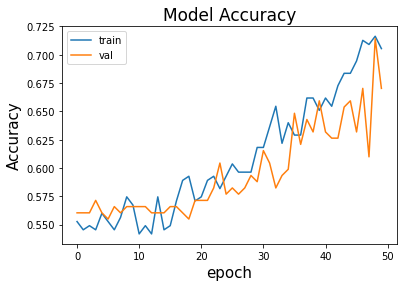

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=17)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_result.jpg')

# Create New Model 모델 읽어올 때

In [64]:
model = load_model('../../Data/final_data/model/video_model/video_model.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2)

new_model = Model(inputs=model.input,
                  outputs=(model.layers[-3].output, 
                           # GlobalAveragePooling2D()(x) 하기전 결과값, Convolution과 Activation까지한 layer
                           # Convolution layer까지가 공간적인 특징을 가진 layer라서 여기까지만된 layer 사용함.
                           model.layers[-1].output)) 
                           # output 2개짜리(모든 layer 통과한 결과값)

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

# 비디오 결과물 도출할 때

In [225]:
import cv2

cap = cv2.VideoCapture('video/no_flood_cho_ryang2.mp4')



fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter('final_output7.avi', fourcc, 30.0, (448, 448))
font = cv2.FONT_HERSHEY_SIMPLEX

car_cascade = cv2.CascadeClassifier()
car_cascade.load('cars.xml')
while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.resize(frame, (224,224))
    
    


    
    test_img = img_to_array(frame)
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)

    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280)
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)
    
#     final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)

#     final_output = ~np.uint8(final_output)
#     final_output = cv2.cvtColor(final_output, cv2.COLOR_GRAY2BGR)    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    
#     alpha_channel = np.ones(final_output.shape, dtype=final_output.dtype) * 50 #creating a dummy alpha channel image.

#     b_channel, g_channel, r_channel = cv2.split(frame)
#     img_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
# #     img_BGRA = cv2.bitwise_and(frame, final_output)
    img_BGRA = cv2.resize(frame, (448,448))
    
    gray = cv2.cvtColor(img_BGRA, cv2.COLOR_BGR2GRAY) 

    # Detects cars of different sizes in the input image 
    cars = car_cascade.detectMultiScale(gray, 1.01, 10,  minSize=(45,45))
      
    # To draw a rectangle in each cars 
    for (x,y,w,h) in cars:
        img_BGRA = cv2.rectangle(img_BGRA,(x,y),(x+w,y+h),(0,0,255),2) 
    
    x = 255
    if (100-pred[0][1]*100) > 50:
        x = 0
        
    cv2.putText(img_BGRA,  
                '%.2f%% Flood, ' % (100 - pred[0][1]*100),  
                (50, 50),  
                font, 1,  
                (0, x, 255),  
                2,  
                cv2.LINE_4) 
#     cv2.imshow('final',img_BGRA)
#     plt.imshow(img_BGRA)
#     plt.show()
    writer.write(img_BGRA)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
writer.release()
cv2.destroyAllWindows()
print("The video was successfully saved") 

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


# Draw Activation Map

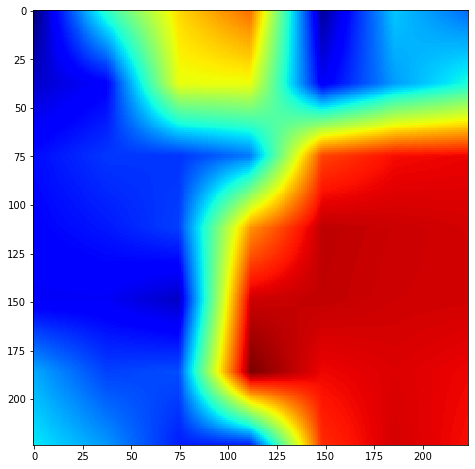

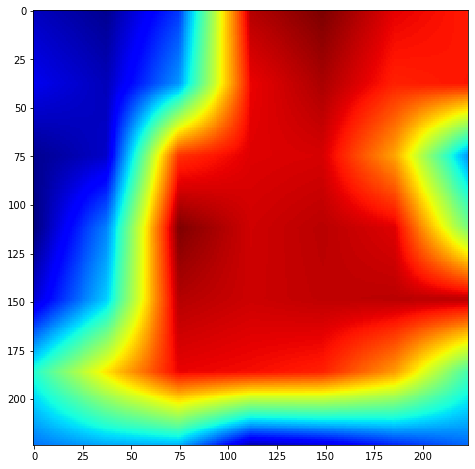

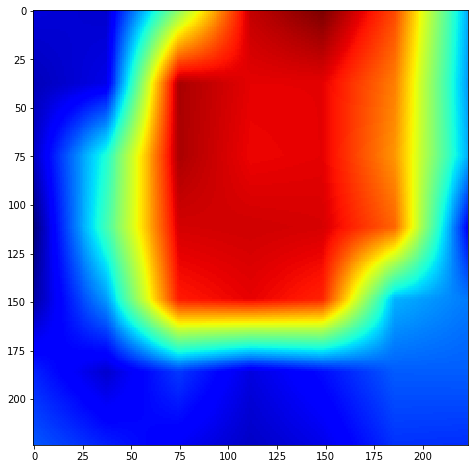

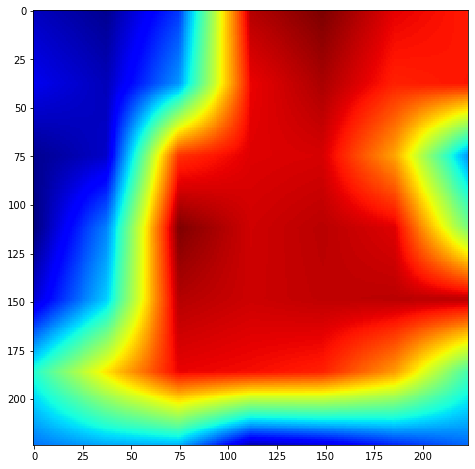

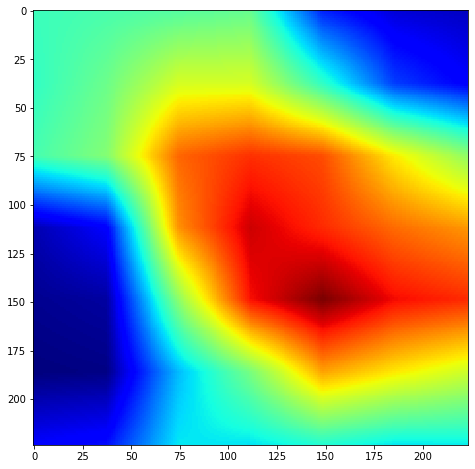

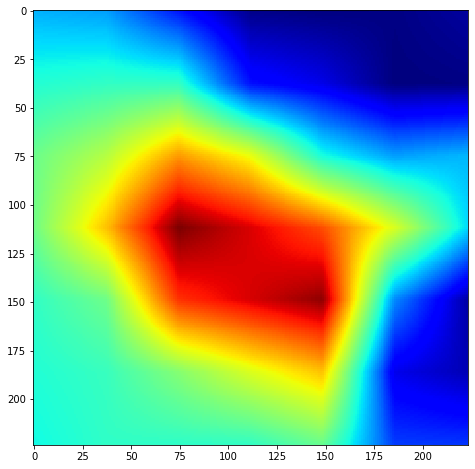

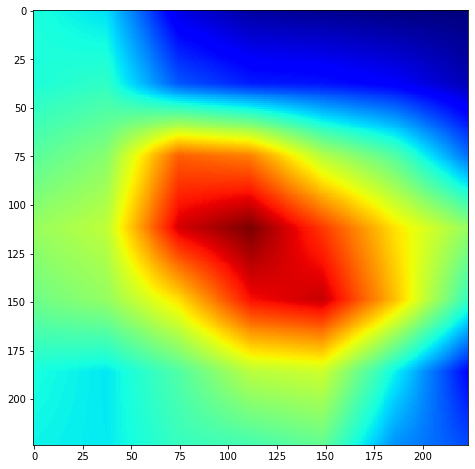

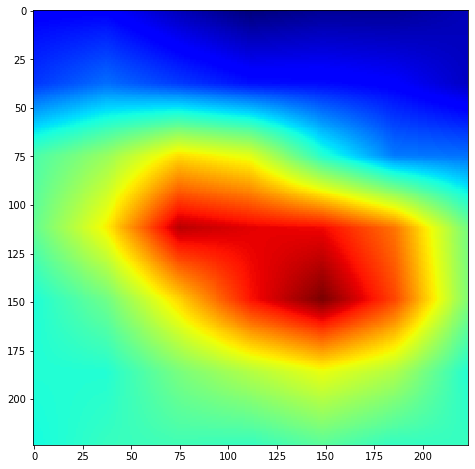

In [19]:
for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(BASE_PATH, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)
    
    # 이 다음 코드부터 Activation Map 코드
    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280), squeeze 함수는 1짜리 axis는 없애줌.
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # 이미지를 확대해줌 32배
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    
    plt.figure(figsize=(8,8))
    plt.imshow(final_output, cmap='jet')

# Result

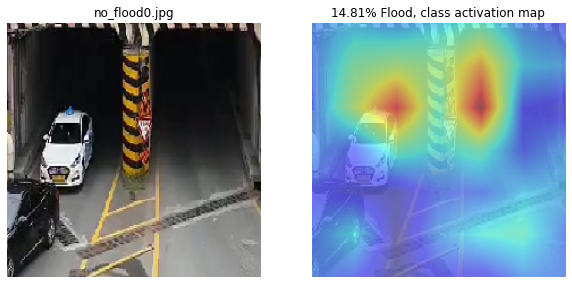

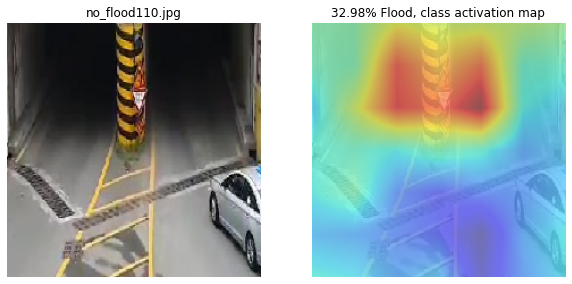

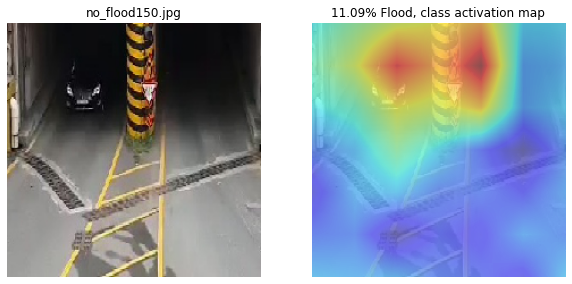

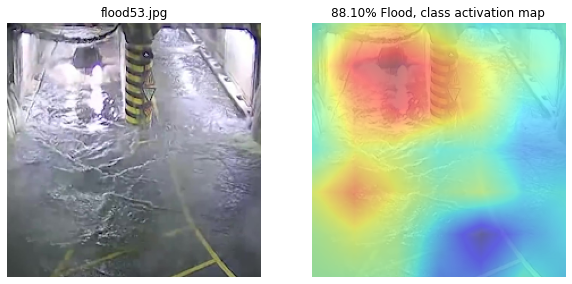

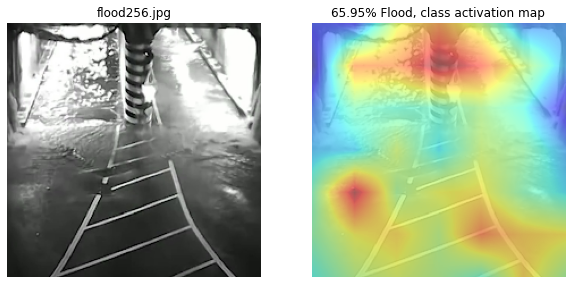

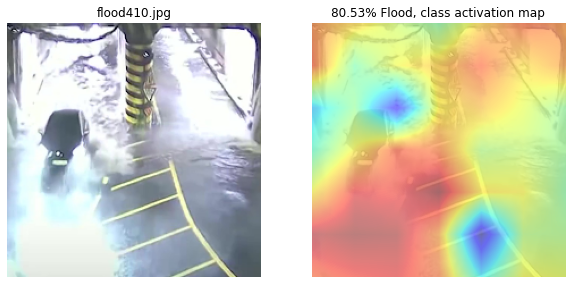

In [182]:
for i, parking in enumerate(test_list):
    test_img = img_to_array(load_img(os.path.join('learning_data', parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = new_model.predict(test_input)

    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280)
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(test_img.astype(np.uint8))
    plt.title(parking.split('/')[1])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(test_img.astype(np.uint8), alpha=0.4)
    plt.imshow(final_output, alpha=0.5, cmap='jet')
    plt.title('%.2f%% Flood, class activation map' % (100 - pred[0][1]*100))
    plt.axis('off')
    plt.savefig('result{}.jpg'.format(i))
    plt.savefig('result{}.jpg'.format(i))
    plt.show()


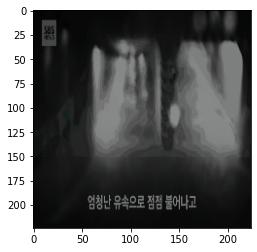

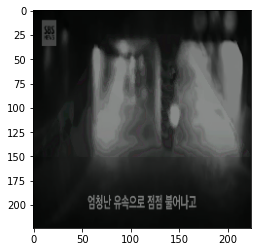

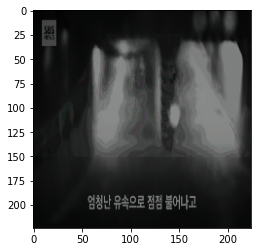

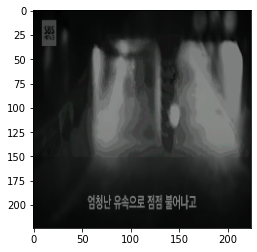

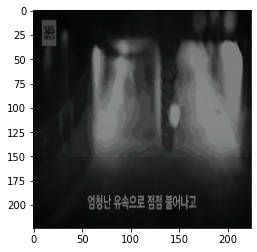

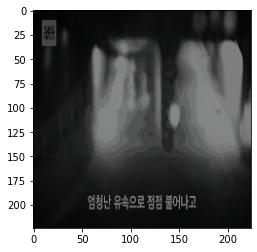

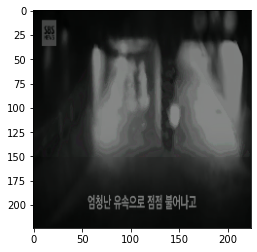

KeyboardInterrupt: 

In [28]:
import cv2

cap = cv2.VideoCapture('video/video3.mp4')

while(cap.isOpened()):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frame = cv2.resize(frame, (224,224))
    test_input = preprocess_input(np.expand_dims(frame.copy(), axis=0))
    pred = model.predict(test_input)
    
    # 이 다음 코드부터 Activation Map 코드
    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280), squeeze 함수는 1짜리 axis는 없애줌.
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # 이미지를 확대해줌 32배
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    
#     plt.figure(figsize=(8,8))
    final_output = np.uint8(final_output)
    final_output = cv2.cvtColor(final_output, cv2.COLOR_GRAY2BGR)
    
    vertices = np.array([[(0,150),(75,25),(150,25),(224,150)]], dtype=np.int32)

    final_output = region_of_interest(final_output, vertices)

  
    img_BGRA = cv2.bitwise_and(frame, final_output)
#     last = cv2.bitwise_and(frame, img_BGRA, img_BGRA)
    plt.imshow(frame)
    plt.imshow(img_BGRA,alpha=0.5, cmap='jet')
    plt.pause(3)
#     cv2.imshow('frame',last)
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [66]:
np.shape(final_output)

(224, 224)

# RGB 채널 분리

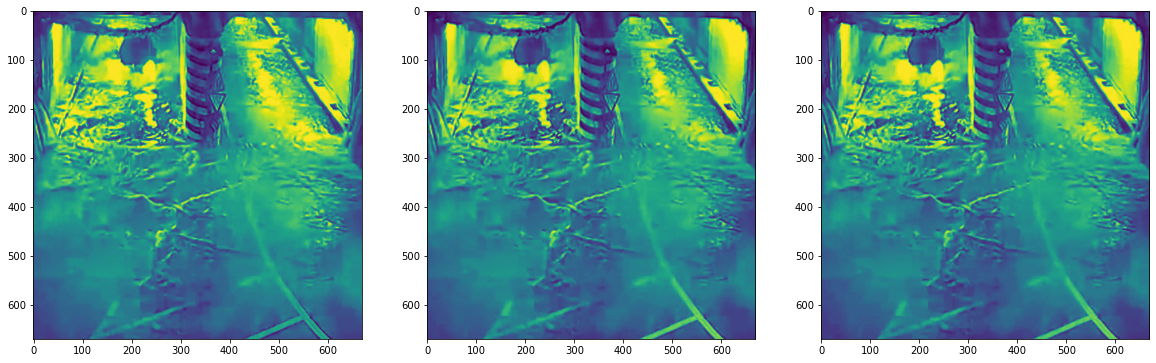

In [107]:
img_b,img_g,img_r = cv2.split(abnormal_img)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img_b)
plt.subplot(1,3,2)
plt.imshow(img_g)
plt.subplot(1,3,3)
plt.imshow(img_r)

# histogram equalization

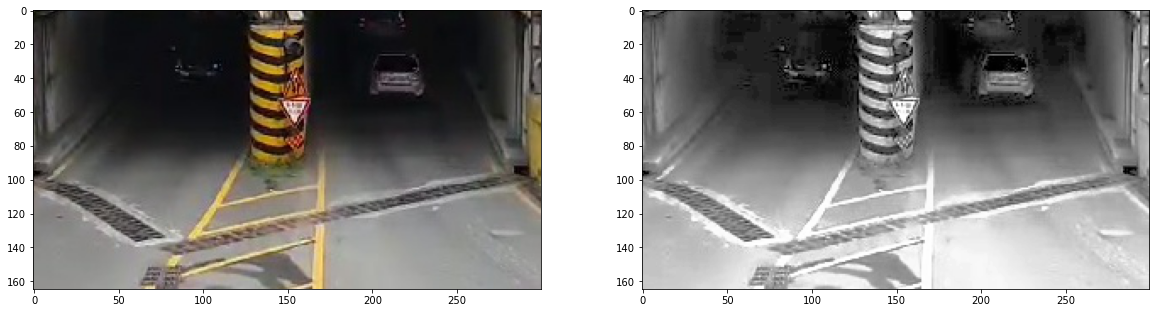

In [129]:
histo_img = cv2.equalizeHist(cv2.cvtColor(normal_img, cv2.COLOR_RGB2GRAY))
# res = np.hstack((cv2.cvtColor(abnormal_img, cv2.COLOR_RGB2GRAY),histo_img)) #stacking images side-by-side
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(normal_img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(histo_img, cmap = 'gray')
plt.savefig('histogram_eq.jpg')

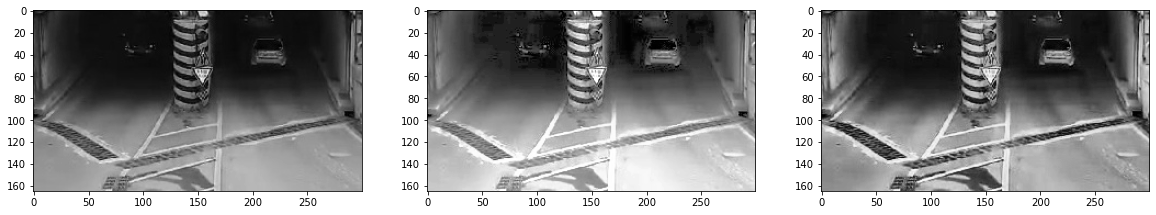

In [130]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
cl1 = clahe.apply(cv2.cvtColor(normal_img, cv2.COLOR_RGB2GRAY))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(normal_img, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(histo_img, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(cl1, cmap='gray')
plt.savefig('histogram_eq22.jpg')

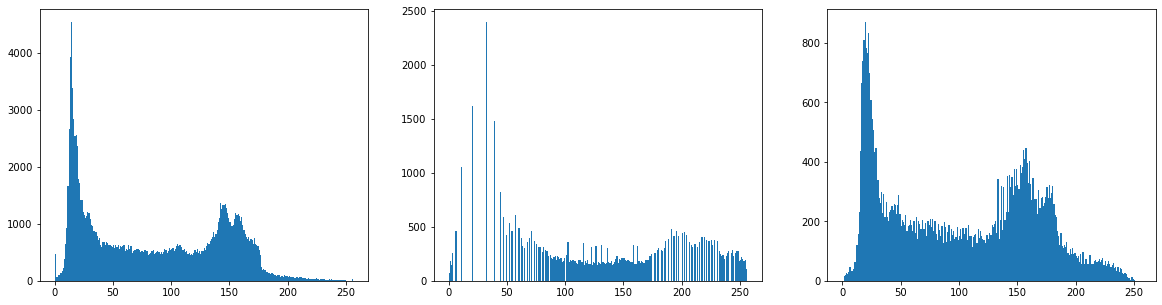

In [131]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(normal_img.ravel(), 256, [0,256]); 
plt.subplot(1,3,2)
plt.hist(histo_img.ravel(), 256, [0,256]); 
plt.subplot(1,3,3)
plt.hist(cl1.ravel(), 256, [0,256]);
plt.savefig('histogram_test.jpg')